## GeoPointGAN - Example notebook

This is an example notebook for *GeoPointGAN*, a generative model for geospatial point coordinates with a built-in provacy mechanism. This notebook uses `PyTorch` and is optimized for [Google Colab](colab.research.google.com/).

We first need to load required packages:

In [1]:
# Check version of pytorch and cuda -- following assumes PyTorch version 1.11.0 and cuda 11.3
! python -c "import torch; print(torch.__version__)"
! python -c "import torch; print(torch.version.cuda)"

1.11.0+cu113
11.3


In [2]:
!pip install wget --quiet

In [3]:
import wget
wget.download("https://raw.githubusercontent.com/konstantinklemmer/geopointgan/main/src/model.py", "model.py")
wget.download("https://raw.githubusercontent.com/konstantinklemmer/geopointgan/main/src/utils.py", "utils.py")

'utils.py'

In [7]:
from math import e
import torch
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import cuda, FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader

import argparse
import datetime
import sys
import requests
import io
import os
import random
from time import sleep

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

from utils import *
from model import *

Now we define a `train` function, including our training loop.

In [8]:
def train(args):
  ### TRAINING CONFIGURATION

  # READ ARGS
  dset = args.dset
  random_state = args.random_state
  path = args.path
  n_samples = args.n_samples
  n_points = args.n_points
  draw_with_replacement = args.draw_with_replacement
  n_epochs = args.n_epochs
  lr = args.lr
  embed_dim_d = args.embed_dim_d
  embed_dim_g = args.embed_dim_g
  d_train = args.d_train
  label_flip = args.label_flip
  eps = args.eps
  enable_plotting = args.enable_plotting
  save_model = args.save_model

  # SET DEVICE
  DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # SET SEED
  torch.manual_seed(random_state) # Initiate random seed

  # CREATE SAVE PATH
  models_path = os.path.join(path, 'models')
  if not os.path.exists(models_path):
    os.mkdir(models_path)
  
  # INITIATE
  print('Training - Dataset: %s - Label flip: %s - Eps: %f' % (dset, label_flip, eps))

  # SET PROBABILITIES FOR PRIVACY MECHANISM
  p, q = dp_proba(eps, 2)
  if label_flip == False:
    eps = -1
  
  # LOAD & PROCESS DATA  
  if dset == "porto":
    url="https://raw.githubusercontent.com/konstantinklemmer/geopointgan/master/data/porto-test.csv"
    s=requests.get(url).content
    c=pd.read_csv(io.StringIO(s.decode('utf-8')))
    c.columns = ["x","y"]
    c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
    c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1
  elif dset == "new_york":  
    url="https://raw.githubusercontent.com/konstantinklemmer/geopointgan/master/data/nyc-test.csv"
    s=requests.get(url).content
    c=pd.read_csv(io.StringIO(s.decode('utf-8')))
    c.columns = ["x","y"]
    c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
    c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1
  elif dset == "beijing":
    url="https://raw.githubusercontent.com/konstantinklemmer/geopointgan/master/data/beijing-test.csv"
    s=requests.get(url).content
    c=pd.read_csv(io.StringIO(s.decode('utf-8')))
    c.columns = ["x","y"]
    c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
    c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1
  elif dset == "3d_road": 
    url="https://archive.ics.uci.edu/ml/machine-learning-databases/00246/3D_spatial_network.txt"
    s=requests.get(url).content
    c=pd.read_csv(io.StringIO(s.decode('utf-8')))
    c.columns = ["id","x","y","z"]
    c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
    c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1
    c["z"] = 2 * (c["z"]-min(c["z"]))/(max(c["z"])-min(c["z"])) - 1
  else:
    raise ValueError('Invalid dataset.')

  data_scaled = c
  
  #Set dimensions
  if dset == "3d_road":
    n_dim = 3
  else:
    n_dim = 2

  #Generate training samples by drawing random samples from the real data
  total_n_points = len(data_scaled["x"]-1)
  
  #Generate training labels
  if label_flip==True:
    D_labels = torch.bernoulli(torch.tensor([p] * total_n_points)).reshape(total_n_points,1)
    data_scaled["d_lab"] = D_labels.numpy()
  
  if label_flip==True:
    data = torch.zeros(n_samples,n_points,n_dim+1)
  else:
    data = torch.zeros(n_samples,n_points,n_dim)
  
  for i in range(n_samples-1):
    if draw_with_replacement:
      idx = np.random.randint(low=0,high=total_n_points, size=n_points) # Draw with replacement
    else:
      idx = np.random.choice(total_n_points, n_points) # Draw without replacement
    sample = data_scaled.iloc[idx]
    if label_flip==True:
      sample = sample.to_numpy().reshape(n_points,n_dim+1)
    else:
      sample = sample.to_numpy().reshape(n_points,n_dim)
    data[i,:,:] = torch.tensor(sample)
  train_data = torch.tensor(data)
  
  # Define data loader
  train_loader = DataLoader(train_data, batch_size=1, shuffle=True, drop_last=True, num_workers=2, pin_memory=True)
  
  # Define G and D
  D = PointNet_Discriminator(code_nfts = embed_dim_d, n_dim = n_dim).to(DEVICE)
  G = PointNet_Generator(code_nfts = embed_dim_g, n_dim = n_dim).to(DEVICE)
  # Loss criterion
  criterion = nn.BCELoss()
  # Initialize D and G optimizer
  D_opt = torch.optim.AdamW(D.parameters(), lr=lr, betas=(0.5, 0.999))
  G_opt = torch.optim.AdamW(G.parameters(), lr=lr, betas=(0.5, 0.999))
  scheduler_D = torch.optim.lr_scheduler.MultiStepLR(D_opt, milestones=[5000,50000,90000], gamma=0.1)
  scheduler_G = torch.optim.lr_scheduler.MultiStepLR(G_opt, milestones=[5000,50000,90000], gamma=0.1)
  # Define fake and real point labels
  D_labels = torch.ones([n_points, 1]).to(DEVICE) # Discriminator Label to real
  #D_labels = D_labels - 0.1 # Can skip that line - Just a trick known to work well with GANs
  D_fakes = torch.zeros([n_points, 1]).to(DEVICE) # Discriminator Label to fake
  
  gen_loss = []
  disc_loss = []
  check_step = []
  step = 0 # Initiate training step
  g_step = 0
  if n_dim==3:
    z_img = torch.randn(10000, n_dim, 1).to(DEVICE) # Initialize random noise for generating images
  else:
    z_img = torch.randn(total_n_points, n_dim, 1).to(DEVICE) # Initialize random noise for generating images
  
  for e in range(n_epochs):
    # Within each iteration, we will go over each minibatch of data
    for minibatch_i, (x_batch) in enumerate(train_loader):
      # Get data
      x_batch = x_batch.float().to(DEVICE)
      if label_flip==True:
        x = x_batch[:,:,:n_dim]
        D_labels = x_batch[:,:,-1].reshape(n_points,1)  
        D_fakes = torch.bernoulli(torch.tensor([q] * n_points)).reshape(n_points,1).to(DEVICE)
      x = x.permute(1,2,0)
  
      #Train Discriminator
      for d in range(d_train): #Train Disc d_train steps over Generator
        x_outputs = D(x)
        z = torch.randn(n_points, n_dim, 1).to(DEVICE)
        z_gen, _ = G(z)
        z_gen = z_gen.reshape(n_points, n_dim, 1)
        z_outputs = D(z_gen)
        D_x_loss = criterion(x_outputs, D_labels)
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss 
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        scheduler_D.step()
      # Training Generator
      g_step += 1
      z = torch.randn(n_points, n_dim, 1).to(DEVICE)
      z_gen, _ = G(z)
      z_gen = z_gen.reshape(n_points, n_dim, 1)
      z_outputs = D(z_gen)
      G_z_loss = criterion(z_outputs, D_labels)
      G_loss = G_z_loss
      G.zero_grad()
      G_loss.backward()
      G_opt.step()
      scheduler_G.step()
      gen_loss.append(G_loss.item())
      disc_loss.append(D_loss.item())
      # Training utilities: Saving models, plotting and loss progression
      if save_model:
        if step % 500 == 0:
          torch.save(G,'%smodels/G_%s_eps%s_ep%i.pkl.gz' % (path,dset, str(eps), n_epochs) )
          torch.save(D,'%smodels/D_%s_eps%s_ep%i.pkl.gz' % (path,dset, str(eps), n_epochs) )
      if enable_plotting:
        if step % 500 == 0:
          with torch.no_grad():
            G.eval()
            exp_points = get_sample_points(G, z_img, n_dim)
            clear_output()
            plt.figure(0)
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            ax.scatter(exp_points[:,0],exp_points[:,1],s=0.1,alpha=0.1,c="black")
            ax.set_facecolor('white')
            ax.set_title('Step: %i' %step)
            plt.show()
            sleep(1)
            G.train()                    
      if step % 500 == 0:
        print('Epoch %d [%d/%d] - G Loss: %.3f - D Loss: %.3f - Learning rate: %.6f' % (e + 1, minibatch_i, len(train_loader), G_loss.item(), D_loss.item(), D_opt.param_groups[0]['lr']))
      # Increment step
      step = step + 1

We can now define our setting and test the model:

<Figure size 432x288 with 0 Axes>

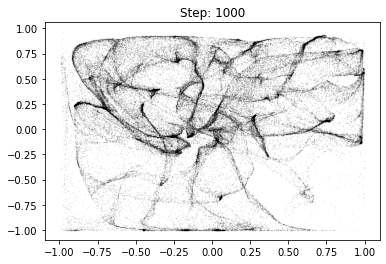

Epoch 2 [0/1000] - G Loss: 0.696 - D Loss: 1.386 - Learning rate: 0.000040


KeyboardInterrupt: ignored

In [9]:
if __name__ == '__main__':
  
  parser = argparse.ArgumentParser(description='GeoPointGAN')
  # Data
  parser.add_argument('-d', '--dset', type=str, default='porto', 
                      choices=['new_york', 'porto', 'beijing', '3d_road'])
  # Utilities
  parser.add_argument('-s', '--random_state', type=int, default=99)
  parser.add_argument('-p', '--path', type=str, default='./')
  # Training setting 
  parser.add_argument('-ns', '--n_samples', type=int, default=1000)
  parser.add_argument('-np', '--n_points', type=int, default=7500)
  parser.add_argument('-draw', '--draw_with_replacement', type=bool, default=False)
  parser.add_argument('-ne', '--n_epochs', type=int, default=100)
  parser.add_argument('-lr', '--lr', type=float, default=0.00004)
  # Model setting
  parser.add_argument('-embd', '--embed_dim_d', type=int, default=256)
  parser.add_argument('-embg', '--embed_dim_g', type=int, default=256)
  parser.add_argument('-dt', '--d_train', type=int, default=1)
  # Privacy setting
  parser.add_argument('-lf', '--label_flip', type=bool, default=True)
  parser.add_argument('-eps', '--eps', type=float, default=2)
  # Logging & plotting
  parser.add_argument('-plot', '--enable_plotting', type=bool, default=True)
  parser.add_argument('-save', '--save_model', type=bool, default=True)
  parser.add_argument('-f') #Dummy to get parser to run in Colab

  args = parser.parse_args()

  out = train(args)